# Dynamic Model of the Melting Process of a Cell filled with Phase Change Material (PCM)

## Introduction

Switzerland's 2050 climate goal has a strong impact on the energy market. Energy, CO2 and energy import must now be drastically minimized. The building sector has a significant impact, 30% of the energy consumption and 25% of the CO2 emissions go to the residential sector. The current global and ecological changes show how close Switzerland is to an energy shortage. Summers are getting hotter, winters are getting colder and the winter electricity gap is becoming more pronounced. Precisely for these reasons it is now of necessity to bring innovative and sustainable solutions to the market that can  store energy seasonally.

A newly published research from the ETH shows, that half of Switzerlands Energy Import for the heating sector can be eliminated with the introduction of thermal seasonal energy storage systems. The following graph shows the energy supply from a thermal solar system in red and the energy consumption of a single family house. Both of the energy are as large as the other. This graph shows, that enough energy is supplied but at the wrong time. Therefore thermal energy storages can be used. To transfer the surplus energy from summer into winter. 
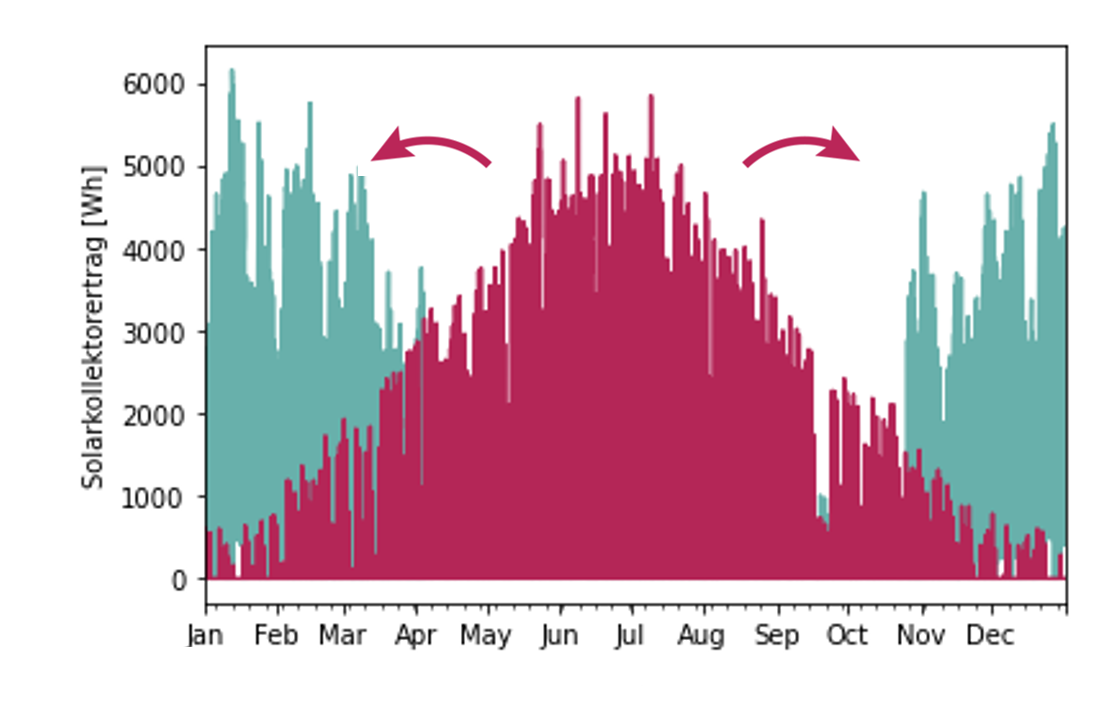

Phase change materials (PCM) are very well suited for that. Compared to a conventional water storage tank, a storage tank filled with PCM has a three times higher energy density. Thermal energy can be stored in the phasechange material by liquefying the solid PCM. When the PCM is activated at a later time and becomes solid again, the thermal energy can be reused. 

A storage system, which consists of many small cells filled with PCM, can bring the surplus energy from the summer into the winter without any losses. Furthermore ecological phase change material can be used and therefore the storage system could save around 2tons of $ CO_2 $ if a oil heating system is replaced.


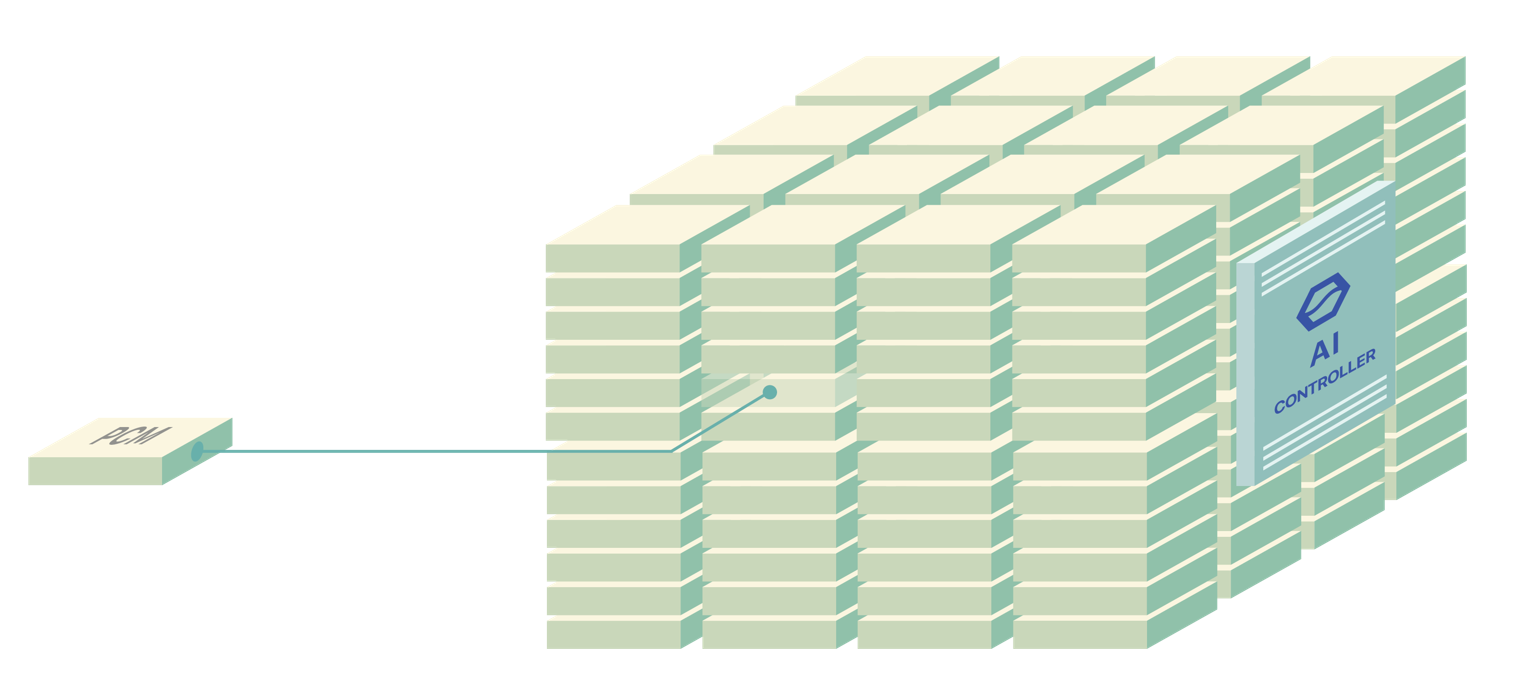
> Figure 1: Scheme  of the thermal energy Storage System. The cells in the tank are controlled by a smart controller that can charge the cells with lowcost surplus energy in the summer and in the winter it can activate the cells in a cost efficient way

Placed in a single-family home, the cells of the storage system can be charged during summer with low-cost surplus energy from renewably energy sources (photovoltaics, heat pumps or solar thermal systems). Once loaded the big advantage of system is that a charged storage cell doesn’t lose energy over time.
In winter, the storage system releases its energy to the building when needed by activating a cell. The intelligent regulation of the cells can optimize the use of the stored energy and make it costefficient.


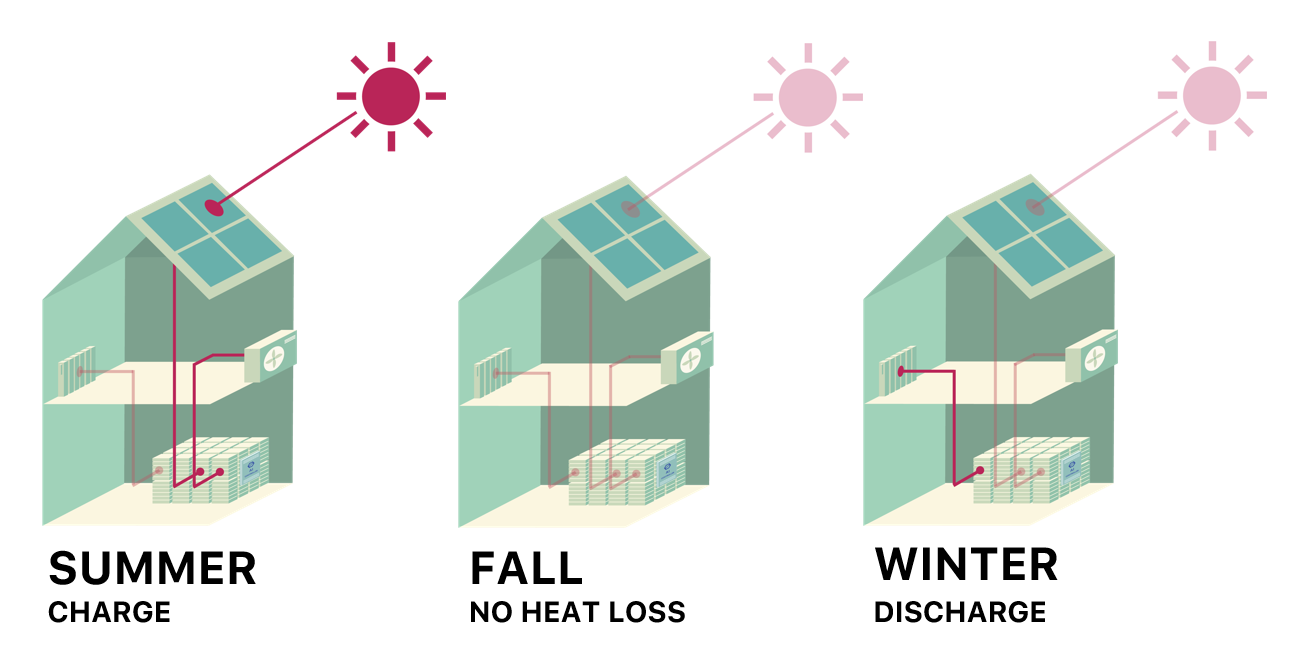


In this project, the charging behavior of such a PCM cell is modeled dynamically. The temperature change in the cell is analysed and different heat exchanger areas are discussed in this report. In addition it is discussed how the melting process could be tested with a test bench. 

To evaluate the melting process of a phase change material the following steps will be discussed in this report:

**Objectives:**
- Analyse the melting process of a phasechange material
- Obtain the mathematical model as a system of Differential Algebraic Equations (DAE) from the thermal circuit
- Transfrom the system of DAE into state-space representation.
- Find the steady-state solution.
- Simulate by using Euler methods for numerical integration..
- Discuss how the outcome of the model could be validated with a test bench


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
from IPython.display import Image

\usepackage[ngerman]{babel}


## Physical Model

The PCM cell is melted with hot water that flows on the top surface of the cell. Therefore heat is transfered with convection from the water to the PCM. The PCM that is used in this model is called sodium acetate trihydrate and has a melting temperature at 55°C. 

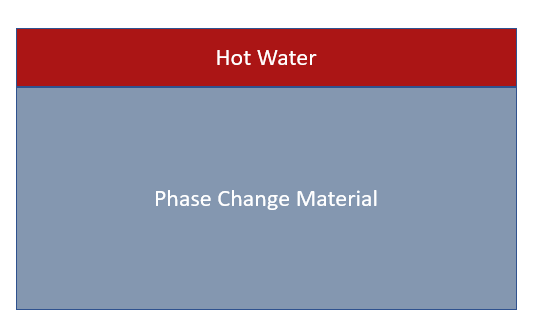
> Figure 2: Scheme that shows how the hot water flows over the phase change material. The water has an inlet-temperature of 85°C. The phase change material is at 20°C at the beginning of the simulation (20°C is around the temperature in which the storage stays)

### Size of one Cell in the Storage System

The surface of the heat transfer are is esential to the charging behavior of a PCM cell. \
$ {Q} = k*A*\Delta T_m $
Therefore the area ist investigated in this dynamic model.

The first evaluation of the melting process is discussed with the following properties. In the discussion part of this report different cell sized will be compared.

In [2]:
L = 0.1
B = 0.1

i = 3
j = 3

l = L/i
bl = B/j
d = 1
              # m length of the cubic room
Spcm_updown = l*d           # m² surface of the pcm 
Spcm_leftright = bl*d

Tmelt = 55
delta_T = 4 # for iteration
n0 = 6 # Temperature of interest

### Physical Properties of the Phase Change Material

In [3]:
# used PCM: Sodium Acetate Trihydrate with a Melting Temperature of 55°C

PCM = {'Conductivity': [1.1, 1.1, 1.1],  # W/(m·K)
        'Density': [1280, 1280, 1280],        # kg/m³
        'Specific_heat': [3000, 2100, 265000/delta_T],  # J/(kg·K)
        'Width': [1, 1, 1],
        # 'Surface': [Spcm_b, Spcm_b, Spcm_b], # m²
        'Slices': [3, 3, 3]}                # number of  slices
PCM_Data = pd.DataFrame(PCM, index=['Liquid', 'Solid', 'Phasechange'])

### Capacity of a Cell

The mass of the PCM Cell is $$ m = L* B * \frac{2}{3} * \rho = 8.53 kg$$ and the temperature differences are: $$ \Delta T_1 = T_m - T_0 = 55°C -20°C = 35°C $$ $$ \Delta T_2 = T_{in} - T_m = 85°C -55°C = 30°C$$ $$ T_m = 55 °C$$ $$E_{cell} = m*(c_{p,liquid}* \Delta T_1 + h_{melt}+ c_{p,solid}* \Delta T_2) = 3702.15 kJ = 1.02 kWh $$  

Therefore around 1kWh thermal Energy can be stored in one PCM cell of the storage. Around 1/10 is stored in latent heat whereas the rest is stored in sensible heat.

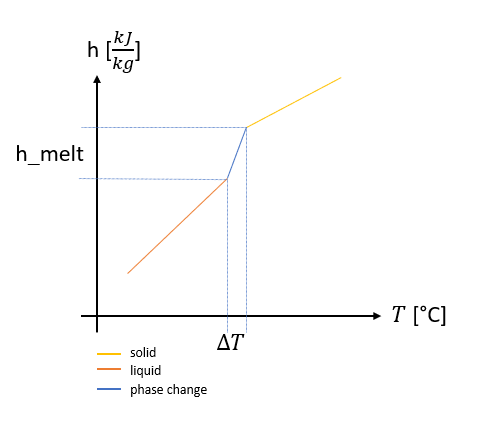
> Figure 3: h-T diagram of the phase change material

### Properties of the Heat Transfer Fluid

In [4]:
Water = {'Density': 997,                      # kg/m³
       'Specific_heat': 4186}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
Water_Data = pd.DataFrame(Water, index=['Properties'])

## Description of the Thermal Circuit

This Scheme shows the Thermal Circuit of one cell filled with PCM. The heat transfer fluid is water and the PCM is sodium acetate water mixture with the melting point @ 55°C.

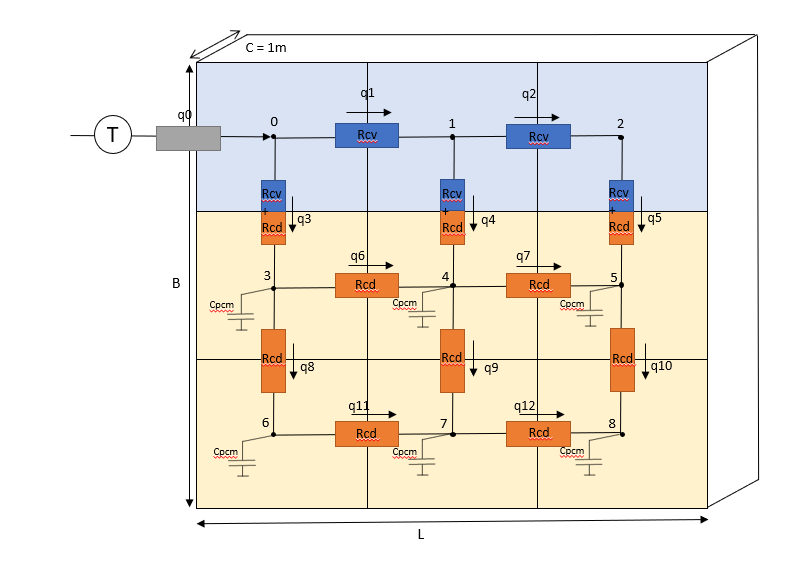
> Figure 4: Thermal circuit of the melting process. The temperature of interest is the temperature at node 8.

Heat transfert is:
- through the PCM
- convection from the flowing water to the solid/melting/liquid PCM
- temperature sources:
    - $T_{in}$ is at 85°C. This is the entry temperature of the water. The outlet temperature  of the heat exchanger is not known
- flow rate sources:
    - none


### Thermal coductances
#### Conduction
The conductances 1, 2, 3, and 4 of the thermal circuit from Figure 3 model the heat transfer by [conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction). Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

Conduction through the pcm material: 

Up/down:  $$𝐺_{𝐶𝐷,𝑈𝐷}=\frac{k}{b}⋅𝐴_{𝑈𝐷}=  \frac{1.1 \frac{𝑊}{m𝐾}}{0.033𝑚}⋅0.33𝑚^2 = 11 \frac{𝑊}{𝐾} $$



Right/Left: $$ 𝐺_{𝐶𝐷,𝑅𝐿}=\frac{𝑘}{𝑙}⋅𝐴_{𝑅𝐿}=0.11 \frac{𝑊}{𝐾} $$

In [5]:
G_cud = PCM_Data.Conductivity['Liquid'] / bl * Spcm_updown
G_crl = float(PCM_Data.Conductivity['Liquid'] / l * Spcm_leftright)

#### Calculation of the convection coefficient 

To calculate the convection coefficient the following formulas are used. All the water properties correlate to the properties @85°C.

$$ v = 0.3643*10^{-6} $$

$$ Re = \frac{u*L}{v} = \frac{10\frac{m}{s}*0.1m}{0.3643*10^{-6}}$$

$$ a = \frac{\lambda}{\rho*c_p}$$

$$ Pr = \frac{v}{a} $$
$$ Nu = 0.644*Re^{\frac{1}{2}} * Pr^{\frac{1}{3}} $$

$$ h = \frac{Nu * k}{L}$$

In [6]:
v = 0.3643e-6
u = 10 
lam = 0.67
#rho = 997
rho = Water_Data.Density['Properties']
c = Water_Data.Specific_heat['Properties']
a = lam/(rho * c)
k = 0.556
Re = u*L/v
Pr = v/a
Nu = 0.644*pow(Re,0.5)*pow(Pr,(1/3))
h = Nu*k/L
print(str(round(h,1)) + ' W/(m²⋅K)') # W/(m²⋅K)

7795.7 W/(m²⋅K)


The conductances 1,2,3 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:

- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [7]:
# Convection
Gw = h*Spcm_updown

#### Combined Conduction & Convection

In [8]:
G1 = Gw + G_cud*2
G0 = Gw

### Thermal capacities

The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are of the form:

$$ C_{pcm}= m_{pcm}*c_{pcm}= \rho_w*c_{pcm}*w_{pcm} S $$

where:
- $m_{pcm} = \rho_w w_w S_w$ is the mass of the pcm, kg;
- $c_{pcm}$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_{pcm}$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_{pcm}$ - width of the cell, m;
- $S$ - surface area of the cell, m².

In [9]:
#Capacities
m = PCM_Data.Density['Liquid']*Spcm_leftright*l
Cpcm_solid = m*PCM_Data.Specific_heat['Solid']
Cpcm_liquid = m*PCM_Data.Specific_heat['Liquid']
Cpcm_pc = m*PCM_Data.Specific_heat['Phasechange']
print(m)

1.422222222222222


### Temperature source

The temperature source in this model is the inlet temperature of the hot water which flows over the PCM cell. The inlet temperature ist 85°C.

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ - heat flow vector of size $n_q$ equal to the number of branches;
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.

- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$



### A: incidence matrix

In [10]:
A = np.zeros([13, 9])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3,0], A[4,1], A[5,2], A[6,3] , A[7,4],A[8,3], A[9,4], A[10,5], A[11,6],A[12,8], A[12,7]= -1,-1,-1, -1, -1, -1, -1, -1, -1, -1, -1
A[3,3], A[4,4], A[5,5], A[6,4],  A[8,6], A[9,7], A[10,8], A[12,8], A[11,7], A[7,5] = 1,1,1, 1, 1, 1, 1, 1, 1, 1

In [11]:
np.set_printoptions(suppress=False)
A_Data = pd.DataFrame(A)

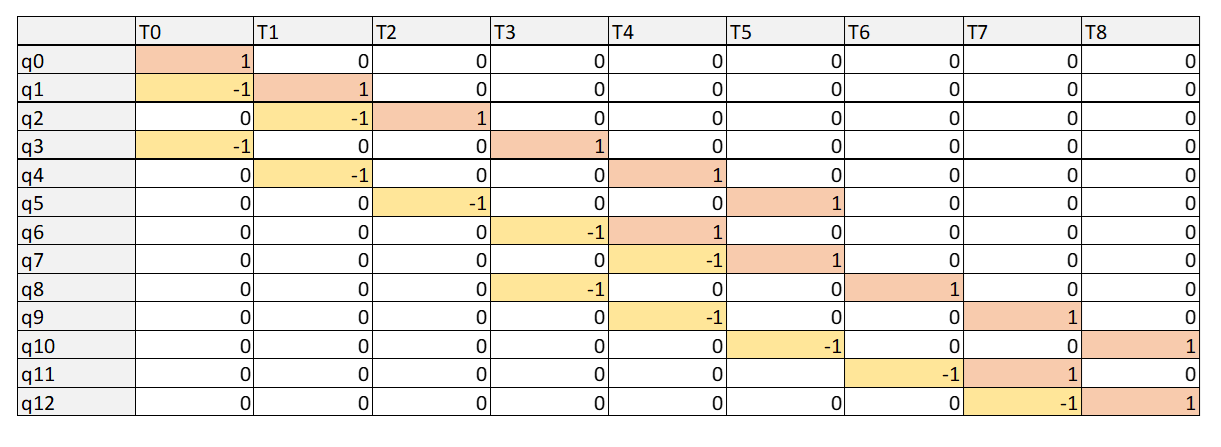
> Figure 5: Incident Matrix

### G: conductance matrix

The conductance matrix of the themal circuit shown in Figure 3 is:

In [12]:
G = np.array([Gw, Gw, Gw, G1, G1, G1, G_crl, G_crl, G_cud, G_cud, G_cud, G_crl, G_crl])
G = np.diag(G)
G_Data = pd.DataFrame(G)
print(G_Data)

            0           1           2           3           4           5   \
0   259.857986    0.000000    0.000000    0.000000    0.000000    0.000000   
1     0.000000  259.857986    0.000000    0.000000    0.000000    0.000000   
2     0.000000    0.000000  259.857986    0.000000    0.000000    0.000000   
3     0.000000    0.000000    0.000000  262.057986    0.000000    0.000000   
4     0.000000    0.000000    0.000000    0.000000  262.057986    0.000000   
5     0.000000    0.000000    0.000000    0.000000    0.000000  262.057986   
6     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
7     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
8     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
9     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
10    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
11    0.000000    0.000000    0.000000    0.000000    0.000000  

### C: capacity matrix

In [13]:
C_solid = np.array([0, 0, 0, Cpcm_solid, Cpcm_solid, Cpcm_solid, Cpcm_solid, Cpcm_solid, Cpcm_solid])
C_solid = np.diag(C_solid)
# Uncomment next line to put 'Air' and 'Glass' capacities to zero 
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
C_solid_data = pd.DataFrame(C_solid)

C_liquid = np.array([0, 0, 0, Cpcm_liquid, Cpcm_liquid, Cpcm_liquid,  Cpcm_liquid, Cpcm_liquid, Cpcm_liquid])
C_liquid = np.diag(C_liquid)
# Uncomment next line to put 'Air' and 'Glass' capacities to zero 
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
C_liquid_data = pd.DataFrame(C_liquid)

Cpcm_pc = np.array([0, 0, 0, Cpcm_pc, Cpcm_pc, Cpcm_pc, Cpcm_pc, Cpcm_pc, Cpcm_pc])
Cpcm_pc = np.diag(Cpcm_pc)
# Uncomment next line to put 'Air' and 'Glass' capacities to zero 
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
C_pc_data = pd.DataFrame(Cpcm_pc)

$$𝑐_{𝑠𝑜𝑙𝑖𝑑}=𝑚_{𝑝𝑐𝑚}⋅𝑐𝑝_{s}= V⋅𝜑⋅𝑐𝑝_𝑠= 29866 \frac{𝑊}{𝐾}$$
$$
𝑐_{𝑙𝑖𝑞𝑢𝑖𝑑}=𝑚_{𝑝𝑐𝑚}⋅𝑐𝑝_𝑙=V⋅𝜑⋅𝑐𝑝_𝑙= 42666 \frac{𝑊}{𝐾}
$$
$$𝑐_{𝑝ℎ𝑎𝑠𝑒𝑐ℎ𝑎𝑛𝑔𝑒}=𝑚_{𝑝𝑐𝑚}⋅ℎ_{𝑚𝑒𝑙𝑡}=V⋅𝜑⋅ℎ_{𝑚𝑒𝑙𝑡}= 3768300 \frac{𝑊}{𝐾}$$

### b: temperature source vector

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches (in this example 12). An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)). 

For the thermal circuit shown in Figure 3,

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &0  &0  &0  &0 
\end{matrix}]^T$$

- $T_o$ is the inlet temperature of the heat transfer fluid, °C;

Since the temperature sorces $T_o$ and $T_{i,sp}$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [14]:
b = np.zeros(13)  
b[[0]] = 1 
print(b)   # branches
f = np.zeros(9)         # nodes

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes (in this example 8). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

the temperature of the node = n0 will be evaluated in this model

In [15]:
y = np.zeros(9)         # nodes
y[[n0]] = 1  

## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure and heat flows) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o]^T$ corresponds to branche 0; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [0]^T$;
    
- $y$ - vector of outputs is a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = n0, the indoor temperature.

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

In [16]:
[As_solid, Bs_solid, Cs_solid, Ds_solid] = dm4bem.tc2ss(A, G, b, C_solid, f, y)
[As_liquid, Bs_liquid, Cs_liquid, Ds_liquid] = dm4bem.tc2ss(A, G, b, C_liquid, f, y)
[As_pc, Bs_pc, Cs_pc, Ds_pc] = dm4bem.tc2ss(A, G, b, Cpcm_pc, f, y)

## Steady-state

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:

- the inlet temperature is $T_o = 85 \, \mathrm{^\circ C}$,

In [17]:
# steady state
b = np.zeros(13)        # temperature sources
b[[0]] = 85      # outdoor temperature

f = np.zeros(9)         # flow-rate sources

θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [85. 85. 85. 85. 85. 85. 85. 85. 85.] °C


The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering $\dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures $\theta_0 ... \theta_7$ are equal to $T_o = 85 \, \mathrm{^\circ C}$. This means that the first evaluation shows that the behavior of the model is not incorrect. 

### System of Diferential Algebraic Equations (DAE)


The inlet temperature is again set to 85°C. There are no flows in the system therefore the vector fQ is set to 0.

In [18]:
bT = np.array([85])     # [To]
fQ = np.array([0])         # [0]
u = np.hstack([bT])

The steady-state value of the output of the state-space representation is:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [19]:
yss = (-Cs_solid @ np.linalg.inv(As_solid) @ Bs_solid + Ds_solid) @ u
print(f'yss = {yss} °C')

yss = [85.] °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = \min -2 / \lambda_i = \min 2 T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [20]:
λ = np.linalg.eig(As_solid)[0]    # eigenvalues of matrix As
λ_1 = -1 / λ
print('Min. Time Constant = ' + str(round(λ_1.min(),1)))
dt = λ_1.min()-0.5     # seconds
print(f'dt = {round(dt,2)} s = {dt / 60:.0f} min')

Min. Time Constant = 14.6
dt = 14.12 s = 0 min


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

In [21]:
print('Settling Time = ' + str(round(dt*4,1))+ 's')

Settling Time = 56.5s


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [22]:
t_resp = 4 * max(-1 / λ)
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

duration = 150000          # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

Settling time: 11127 s = 185.4 min = 3.09 h = 0.13 days
Duration = 150000 s
Number of time steps = 10621


,time
0,0.000
1,14.122
2,28.245
3,42.367
4,56.489
...,...
10616,149922.556
10617,149936.678
10618,149950.801
10619,149964.923


#### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the inlet temperature of the water will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, 

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &0  &0  &0  &0 &0
\end{matrix}]^T$$
and 
$$b_T = [T_o]^T$$
corresponding to branch 0; 
- vector $f_Q$ is zero in this simulation

$$f = [\begin{matrix}
0 &0  &0  &0  &0  &0  &0 &0 &0
\end{matrix}]^T$$

and

$$f_Q = [0]^T$$

corresponding to nodes 0, 4, 6, and 7.

For the thermal circuit, the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero.

In [23]:
u = 85*np.ones([1, n])      # Tisp = 85 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,10611,10612,10613,10614,10615,10616,10617,10618,10619,10620
0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0


#### Time integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In this simulation the time integration varies from the "normal" integration. Due to the phase change in the simulation the integration must be done for every phase seperately. The slope in the solid and liquid phase in the T-h diagram are the values: $ c_{p,solid} = 2.1 \frac{kJ}{kgK}  $ and $c_{p,liquid} = 3 \frac{kJ}{kgK}$. The slope in the phase change area ist $\frac{h_{melt}}{\Delta T} $ the $ \Delta T$ in this simulation is 4K and therefore the slope in the phase change area is $h_{melt} = \frac{265}{4} \frac{kJ}{kgK} = 88.33 \frac{kJ}{kgK}$. \

The T-h-diagram is shown here:

In [24]:
n_s = As_solid.shape[0]                      # number of state variables
θ_exp = 20*np.ones([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = 20*np.ones([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    if θ_exp[n0-3, k] < Tmelt-3:
        θ_exp[:, k + 1] = (I + dt * As_solid) @\
            θ_exp[:, k] + dt * Bs_solid @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As_solid) @\
            (θ_imp[:, k] + dt * Bs_solid @ u[:, k])
    if θ_exp[n0-3, k] > Tmelt+3:
        θ_exp[:, k + 1] = (I + dt * As_liquid) @\
            θ_exp[:, k] + dt * Bs_liquid @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As_liquid) @\
            (θ_imp[:, k] + dt * Bs_liquid @ u[:, k])
    else: 
        θ_exp[:, k + 1] = (I + dt * As_pc) @\
            θ_exp[:, k] + dt * Bs_pc @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As_pc) @\
            (θ_imp[:, k] + dt * Bs_pc @ u[:, k])

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$


In [25]:
y_exp = Cs_solid @ θ_exp + Ds_solid @  u
y_imp = Cs_solid @ θ_imp + Ds_solid @  u

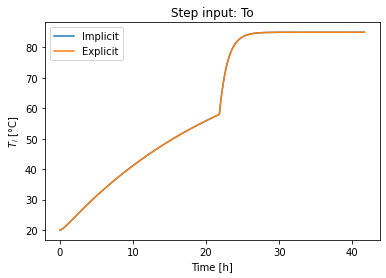

In [26]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Implicit', 'Explicit'])
plt.show()

> Figure 7: The temperature shown in this grafic is the temperature in the node 8. This grafic shows that the PCM Cell is fully melted after 25 hours. 

## Teperature Curves in different nodes

The following graph shows the temperature curves of the different temperature nodes over time. It can be seen, that the Temperatures in nodes 1-5 are at 85°C after less than 60 minutes. This shows, that the convection on top of the cell is dominant in the first minutes. After that the conduction through the pcm is much slower. The temperatures in the nodes 6-8 are meltet after more than 20 hours and reach the temperature of 85°C after 24 hours.

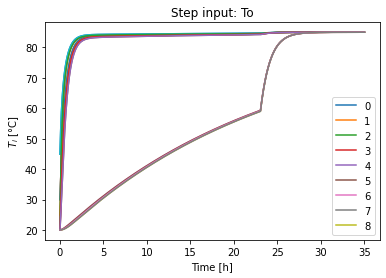
> figure 8: Temperature curve in all nodes

## Temperature curve with different Cell Sizes

The cell investigated in the chapters above have a mass of $ 1.4kg * 6 = 8.2kg$.

Now the Width of the PCM cell should be once half as wide and once double as high. The temperature curve are shown in the next two chapters.
    

### Temperature curve for half the cell size

In [27]:
L = 0.1
B = 0.05

i = 3
j = 3

l = L/i
bl = B/j
d = 1
              # m length of the cubic room
Spcm_updown = l*d           # m² surface of the pcm 
Spcm_leftright = bl*d
print(Spcm_leftright)
print(Spcm_updown)

0.016666666666666666
0.03333333333333333


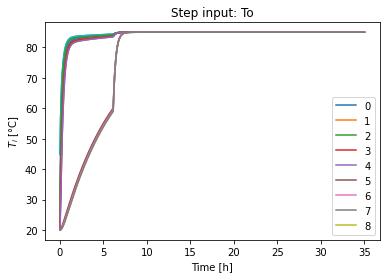
> Figure 9: Temperature curve for half the cell size. The cell has a mass of $ 0.7kg*6 = 4.19 kg$

The cell is melted after around 7 hours. This is 3 times faster than the cell with 8kg pcm in it. This can be explained with the heat transfer area that stays the same and the area for the conduction coefficient is half as high in this example than in the reference scenario.

### Temperature curve for double the cell size


In [28]:
L = 0.1
B = 0.2

i = 3
j = 3

l = L/i
bl = B/j
d = 1
              # m length of the cubic room
Spcm_updown = l*d           # m² surface of the pcm 
Spcm_leftright = bl*d
print(Spcm_leftright)
print(Spcm_updown)

0.06666666666666667
0.03333333333333333


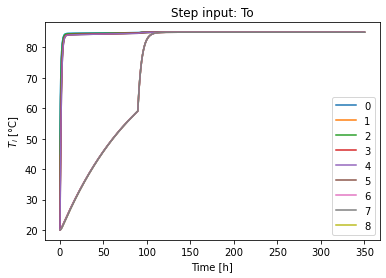
> Figure 9: Temperature curve for half the cell size. The cell has a mass of $ 2.8kg*6 = 16.7 kg$

The pcm cell is meltet at around 100 hours with double the mass. It is also due to the bad conduction coefficient. The convection coefficient stays the same for all three scenarios. If the heat exchange area is as double as hight as shown in figure 9, the temperature curve looks the same as in the reference scenario. This curve can be seen in figure 10. 

In [29]:
L = 0.2
B = 0.1

i = 3
j = 3

l = L/i
bl = B/j
d = 1
              # m length of the cubic room
Spcm_updown = l*d           # m² surface of the pcm 
Spcm_leftright = bl*d
print(Spcm_leftright)
print(Spcm_updown)

0.03333333333333333
0.06666666666666667


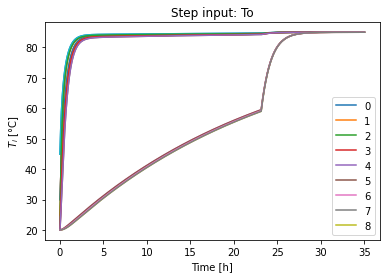
> Figure 10: double the pcm mass but also double the size of the heat exchanger

### Conclusion 
If the size of the pcm cell is doubled also the size of the heat exchanger must be doubled. Otherwise the melting process takes much more time (around 3x). 

## Validation of the model with measurements

The charging and the discharging behaviors of the cells in the seasonal storage are essential. As seen in the results from the dynamic simulation the heat exchanger area is essential to the melting process. To validate the results of the model a test bench will be built to measure the temperatures and the charging power needed during the melting process in a cell.

The test bench is structured to melt one cell and to also test the temperature curves for the activation process of a cell. A thermostate will provide the needed temperature at the entrance of the test bench. To validate the simulation data the inlet temperature of the water will be $T_{in} = 85°C$. 

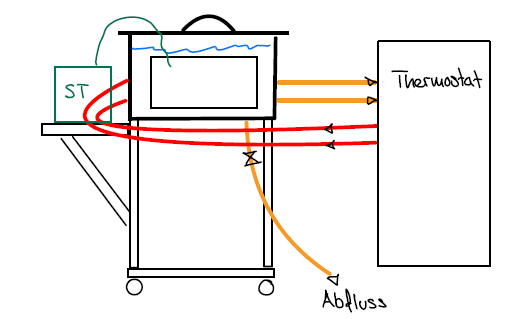
> Figure 11: Scheme of the test bench


The following figure shows how the temperature sensors will be set in the pcm cell. To evaluate the temperature curve the inlet temperatures of the water, the outlet temperature of the water and 5 sensores will be set. All temperature points will be logged with a data logger. The temperature of most interest will be the temperature at the bottom of the pcm cell.

The black part of the test bench is there to be able to also test cells with two heat exchanger areas (one on the top and one at the bottom). 

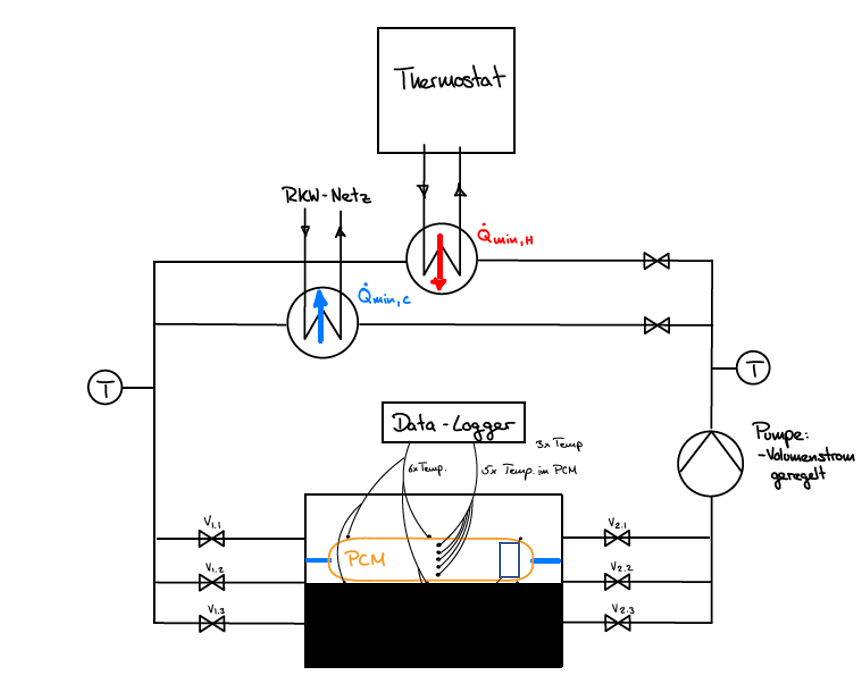
> Figure 12: detailed scheme of the test bench

## Future Simulations

In upcoming simulations cells with two heat exchanger areas will be implemented. Also the discharging behavior of a cell will be implemented in a dynamical model. Therefore the inlet Temperature of the water will be 30°C and  $T_0$ from a cell will be the melting temperature of the pcm. 